In [51]:
%load_ext autoreload
%autoreload 2
import os
import sys
sys.path.insert(1, os.path.dirname(os.getcwd()))


import numpy as np
from utils.network_graph import DirectedGraph, graph_dict_3x3, graph_dict_3x3_2,\
                                graph_dict_4_nodes, create_nxn_graph
from models.O_flows_linear import OFlowsLinear

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [52]:
n = 3
graph_nxn_bi = DirectedGraph(create_nxn_graph(n))

In [53]:
n_t = 100 # number of intervals

links = graph_nxn_bi.get_links()
o_nodes = graph_nxn_bi.get_o_nodes()
num_o_nodes = len(o_nodes)
num_links = len(links)

P_o = graph_nxn_bi.generate_o_assignment_matrix()
o_flows_mat = np.zeros((num_o_nodes, n_t))
link_flows_mat = np.zeros((num_links, n_t))
for i in range(n_t):
    o_flows = graph_nxn_bi.generate_o_flows()[0]
    link_flows = P_o @ o_flows

    o_flows_mat[:, i] = o_flows
    link_flows_mat[:, i] = link_flows

In [54]:
model = OFlowsLinear(graph_nxn_bi)

In [55]:
opt_P, opt_x = model.fit(n_t, link_flows_mat, num_inits=10, threshold=1e-12, verbose=True)

NMSE, iteration 1:  0.0006814501812015133
NMSE, iteration 2:  0.00019775020189154714
NMSE, iteration 3:  0.00012548589757757476
NMSE, iteration 4:  9.235518540676297e-05
NMSE, iteration 5:  7.198838594541888e-05
NMSE, iteration 6:  5.805422732918084e-05
NMSE, iteration 7:  4.812498279744885e-05
NMSE, iteration 8:  4.081227635976459e-05
NMSE, iteration 9:  3.534317830766514e-05
NMSE, iteration 10:  3.113867973911624e-05
NMSE, iteration 11:  2.7805521704924384e-05
NMSE, iteration 12:  2.5105574081232467e-05
NMSE, iteration 13:  2.2879116492737215e-05
NMSE, iteration 14:  2.1019453653870708e-05
NMSE, iteration 15:  1.9446567401158928e-05
NMSE, iteration 16:  1.8096968939880473e-05
NMSE, iteration 17:  1.690978828464493e-05
NMSE, iteration 18:  1.5852395785762664e-05
NMSE, iteration 19:  1.4898337827245487e-05
NMSE, iteration 20:  1.4032014457756588e-05
NMSE, iteration 21:  1.3245425055653868e-05
NMSE, iteration 22:  1.253062817929378e-05
NMSE, iteration 23:  1.1876414881466944e-05
NMSE, i

In [56]:
# some statistics of nmse for different combinations of trained vs random parameters

n = 3
mock_x = np.random.rand(*o_flows_mat.shape) * 1000
mock_P = DirectedGraph(create_nxn_graph(n)).generate_o_assignment_matrix()

print("NMSE opt_P @ opt_x   : ", np.round((np.linalg.norm(opt_P @ opt_x - link_flows_mat) / np.linalg.norm(link_flows_mat)) ** 2, 6))
print("NMSE mock_P @ opt_x  : ", np.round((np.linalg.norm(mock_P @ opt_x - link_flows_mat) / np.linalg.norm(link_flows_mat)) ** 2, 6))
print("NMSE opt_P @ mock_x  : ", np.round((np.linalg.norm(opt_P @ mock_x - link_flows_mat) / np.linalg.norm(link_flows_mat)) ** 2, 6))
print("NMSE mock_P @ mock_x : ", np.round((np.linalg.norm(mock_P @ mock_x - link_flows_mat) / np.linalg.norm(link_flows_mat)) ** 2, 6))

NMSE opt_P @ opt_x   :  0.0
NMSE mock_P @ opt_x  :  0.022672
NMSE opt_P @ mock_x  :  0.190156
NMSE mock_P @ mock_x :  0.21858


In [64]:
# basic visual test
# compare ground truth and predicted od flows for the first interval

np.round(o_flows_mat[:, 0]), np.round(opt_x[:, 0])

(array([892., 559., 979., 702., 910., 795., 908., 531., 157.]),
 array([837., 488., 971., 679., 884., 781., 892., 506., 123.]))

In [57]:
num_od_flows = len(graph_nxn_bi.get_od_pairs())
real_od_flows = np.zeros((num_od_flows, n_t))
predicted_od_flows = np.zeros((num_od_flows, n_t))

for i in range(n_t):
    real_od_flows[:, i] = graph_nxn_bi.get_od_from_o_flows(o_flows_mat[:, i], P_o)[0] + 1
    predicted_od_flows[:, i] = graph_nxn_bi.get_od_from_o_flows(opt_x[:, i], opt_P)[0] + 1

od_errors = ((predicted_od_flows - real_od_flows) / real_od_flows).reshape(num_od_flows * n_t)

In [58]:
hist, bin_edges = np.histogram(od_errors)

(0.0, 560.0)

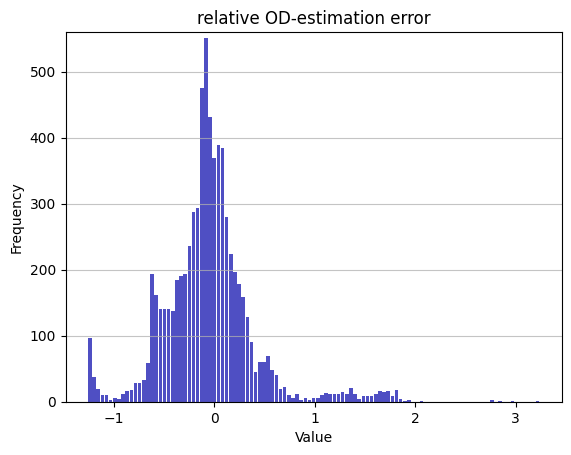

In [59]:
import matplotlib.pyplot as plt

# An "interface" to matplotlib.axes.Axes.hist() method
n, bins, patches = plt.hist(x=od_errors, bins='auto', color='#0504aa',
                            alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('relative OD-estimation error')
maxfreq = n.max()
# Set a clean upper y-axis limit.
plt.ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)


In [60]:
print(f" mean error : {od_errors.mean()}")
print(f" deviation  : {od_errors.std()}")

print(f" mean error in absolute value: {np.abs(od_errors).mean()}")

 mean error : -0.05172377574380592
 deviation  : 0.4564514381166166
 mean error in absolute value: 0.31176994113102835


In [61]:
hist, np.round(np.cumsum(hist / np.sum(hist)), 3), np.round(bin_edges, 2)

(array([ 227, 1214, 3735, 1574,  198,  125,  118,    4,    2,    3]),
 array([0.032, 0.2  , 0.719, 0.938, 0.965, 0.982, 0.999, 0.999, 1.   ,
        1.   ]),
 array([-1.26, -0.81, -0.36,  0.09,  0.54,  0.99,  1.44,  1.89,  2.34,
         2.79,  3.24]))

## Results of blind estimation for 3x3 network :

>##### n_t = 60, 10 trials, nmse threshold = 1e-10
>- mean relative error in absolute values : 41%
>- ~95% of estimated od-flows have relative errors in [-72%, 125%] 

>##### n_t = 100, 10 trials, nmse threshold = 1e-12
>- mean relative error in absolute values : 31%
>- ~95% of estimated od-flows have relative errors in [-126%, 9%] 